In [ ]:
!pip install albumentations --upgrade
!pip install timm

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import json
import glob
import tqdm
import easydict
import logging
import time
import gc

from sklearn import model_selection, metrics

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler

import torchvision
from torchvision import transforms, utils, models

import cv2
import PIL

import albumentations as A
from albumentations import ToTensorV2

In [ ]:
import timm         # pretrained models
import shutil
from catalyst.data.sampler import BalanceClassSampler   # imbalance를 맞춰주는 역할

In [ ]:
model_list = list(set([m.split('_')[0] for m in timm.list_models()]))
model_list[:5]

['ecaresnet101d', 'crossvit', 'swin', 'semobilevit', 'sebotnet33ts']

# Introduction

## Path

In [ ]:
IMAGE_PATH = collections.defaultdict()

In [ ]:
IMAGE_PATH['train'] = '/content/drive/MyDrive/Colab Notebooks/Data/PetFinder/train'
IMAGE_PATH['test'] = ''

In [ ]:
train_images = os.listdir(image_path['train'])
train_images[:3]
#print(f'# of train images: {len(train_images)}')

['71f4580a5125fe00c845503265baa6c0.jpg',
 '718f0b6e65759c71e29a938c6b933d02.jpg',
 '719a57ed1567ddf9ab7407274920db8a.jpg']

In [ ]:
train_images = glob.glob(os.path.join(image_path['train'], '*'))
test_images = glob.glob(os.path.join(image_path['test'], '*'))
train_images[:3]

['/content/drive/MyDrive/Colab Notebooks/Data/PetFinder/train/71f4580a5125fe00c845503265baa6c0.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Data/PetFinder/train/718f0b6e65759c71e29a938c6b933d02.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Data/PetFinder/train/719a57ed1567ddf9ab7407274920db8a.jpg']

## Configuration

In [ ]:
plt.style.use('Solarize_Light2')
plt.style.use('default')
plt.style.use('ggplot')

In [ ]:
CFG = easydict.EasyDict({
    'epochs': 5,
    'batch_size': 128,
    'learning_rate': 1e-2,
    'image_size': 224,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
})

## Helper

### json

In [ ]:
def load_json(train_path, save_path):
    '''json 파일 읽기'''
    # json.load: dict으로 구성
    with open(train_path) as json_file:
        train_meta = json.load(json_file)
    # json.loads: str로 구성 (ex) '''dict'''
    with open(train_path) as json_file:
        train_meta = json.loads(json_file)
    # json.dump: 저장
    with open(save_path) as json_file:
        json.dump(json_file, sort_keys=True, indent=4)  # indent: 들여쓰기로 예쁘게 저장
    return train_meta

def json2df(json_file):
    '''json 파일을 df로 변형'''
    # 1. 데이터를 list로 생성 후 df로 묶어줌
    col1 = [col[''] for col in json_file['']]
    train_df = pd.DataFrame({
        'col1': col1,
    })

    # 2. map을 이용하여 col 생성
    col2_map = {col2['']: col2[''] for col2 in json_file['']}
    train_df['col2'] = train_df.map(col2_map)

def plot_bar(data, x, y, figsize=(20,10)):
    '''형태 암기'''
    plt.figure(figsize=figsize)
    sns.barplot(data=data, x=x, y=y, palette='summer')
    plt.show()

In [ ]:
def set_seed(seed=None):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.bacends.cudnn.benchmark = False
    os.environ['PYTHONHASSEED'] = str(seed)

In [ ]:
# 여기서는 cv2.imread를 사용한 후에 add_subplots를 이용
def plot_select_images(df, col, val, fig_nrows, fig_ncols, figsize=(18,18)):
    images = df.loc[df[col]==val]['image_dir'][:(fig_nrows * fig_ncols)]
    fig = plt.figure(figsize=figsize)
    plt.suptitle(col, fontsize=30)
    i = 1
    for image in images:
        img = cv2.imread(image)
        ax = fig.add_subplots(fig_nrows, fig_ncols, i)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_axis_off()
        i += 1
    plt.show()

# plt.subplots 후 cv2.imread 없이 바로 image 불러옴
def plot_select_images(df, col, val, fig_nrows, fig_ncols, figsize):
    images = df.loc[df[col]==val]['imgae_dir'][:(fig_nrows * fig_ncols)]
    fig, axes = plt.subplots(nrows=fig_nrows, ncols=fig_ncols, figsize=figsize)
    plt.suptitle(col, fontsize=30)
    for i, image in enumerate(images):
        axes.ravel()[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes.ravel()[i].set_axis_off()
    plt.show()

## logging

In [ ]:
'''@contextmanager
def timer(name):
    t0 = time.time()
    logger.into(f'[{name}] start')
    yield
    logger.info(f'[{name}] done in {time.time() - t0:.0f} s.')

def init_logger(log_file=OUTPUT_DIR + 'train.log'):
    logger = logging.getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()    '''

## Read image

In [ ]:
def read_image(image_path, image_name):
    image = cv2.imread(
        os.path.join(image_path, image_name)
    )
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

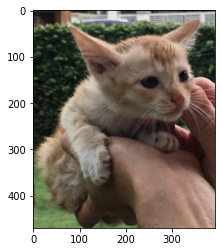

In [ ]:
image = read_image(image_path['train'], '0a0da090aa9f0342444a7df4dc250c66.jpg')
plt.imshow(image)
plt.show()

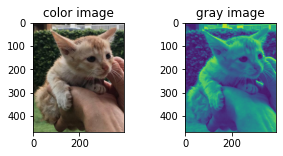

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 2))
color_image = cv2.imread(
    os.path.join(image_path['train'], '0a0da090aa9f0342444a7df4dc250c66.jpg')
)
color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
gray_image = cv2.imread(
    os.path.join(image_path['train'], '0a0da090aa9f0342444a7df4dc250c66.jpg'), cv2.IMREAD_GRAYSCALE
)
#gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
axes[0].imshow(color_image), axes[0].set_title('color image')
axes[1].imshow(gray_image), axes[1].set_title('gray image')
plt.show()

# Read DataFrame

In [ ]:
# df를 분할
train_df, valid_df = model_selection.train_test_split(df, test_size=0.1, random_state=CFG.seed, stratify=df.label.values)

In [ ]:
labels = train_df.groupby('label')['label'].count().div(len(train_df)).mul(100)     # value_counts(normalize=True).mul(100)
others = train_df.groupby('other')['other'].count().div(len(train_df)).mul(100)

fig, axes = plt.subplot(1, 2, figsize=(15,5))
sns.barplot(x=labels.index, y=labels.values, ax=axes[0])
axes[0].set_title('Distribution of target values'), axes[0].set_ylabel('%')
sns.barplot(x=others.index, y=others.values, ax=axes[1])
axes[0].set_title('Image per others'), axes[1].set_ylabel('%')
plt.show()

In [ ]:
train_df.label.value_counts(normalize=True).plot(kind='bar')

# Augmentations

## albumentation

In [ ]:
albu_dict = {
    # Transforms
    'Normalize': A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1.0),
    'GaussNoise': A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=1.0),
    'Emboss': A.Emboss(alpha=(0.2, 0.5), strength=(0.2, 0.7), p=1.0),
    'Sharpen': A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1.0),
    'Solarize': A.Solarize(threshold=128, p=1.0),
    'RandomFog': A.RandomFog(fog_coef_lower=0.3, fog_coef_upper=1, alpha_coef=0.08, p=1.0), # Snow, Rain 등 다양
    'RGBShift': A.RGBShift(p=1.0),
    'ImageCompression': A.ImageCompression(p=1.0),
    'ShiftScaleRotate': A.ShiftScaleRotate(p=1.0),
    'HueSaturationiValue': A.HueSaturationValue(p=1.0),
    'RandomBrightnessContrast': A.RandomBrightness(p=1.0),
    'CLAHE': A.CLAHE(clip_limit=4.0, tile_grid_size=(8,8), p=1.0),  # contrast: 대비

    # Blur
    #'Blur': A.Blur(blur_limit=7, p=1.0),
    'GaussianBlur': A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, p=1.0),

    # Crop
    #'RandomCrop': A.RandomCrop(height=128, width=128, p=1.0),

    # Dropout
    #'MaskDropout': A.MaskDropout(max_objects=1, image_fill_value=0, mask_fill_value=0, p=1.0),
    'CoarseDropout': A.CoarseDropout(max_holes=8, max_height=8, max_width=8, fill_value=0, p=1.0),

    # Geometric
    #'Resize': A.Resize(height=128, width=128, interpolation=1, p=1),
    'Rotate': A.Rotate(limit=90, interpolation=1, p=1.0),
    'HorizontalFlip': A.HorizontalFlip(p=1.0),
    #'VerticalFlip': A.VerticalFlip(p=1.0),
    'Transpose': A.Transpose(p=1.0),
    'RandomScale': A.RandomScale(scale_limit=0.1, interpolation=1, p=1.0),

    # Oneof
    'OneOf': A.OneOf([
        A.CLAHE(clip_limit=2),
        A.MotionBlur(p=0.2),
    ]),
}

print('# of albu:', len(albu_dict))

# of albu: 19


/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [ ]:
albu_names = []
albu_images = []
for albu_name, albu_fn in albu_dict.items():
    img = albu_fn(image=image)['image']
    albu_images.append(img)
    albu_names.append(albu_name)
albu_images.insert(0, image)
albu_names.insert(0, 'Original')

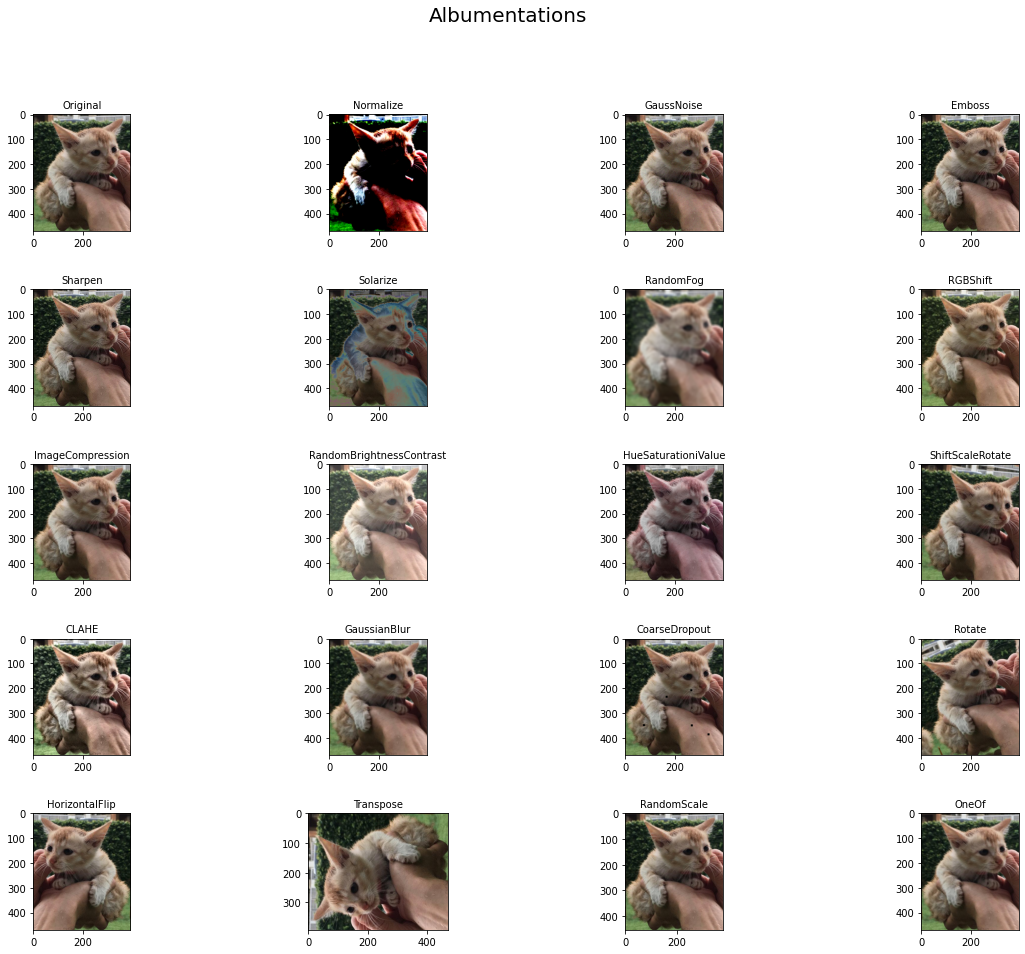

In [ ]:
def plot_multiple_images(names, images):
    fig, axes = plt.subplots(figsize=(20,15), nrows=5, ncols=4, squeeze=False)
    fig.suptitle('Albumentations', fontsize=20)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.5)
    for i, (name, img) in enumerate(zip(names, images)):
        axes.ravel()[i].imshow(img)
        axes.ravel()[i].set_title(name, fontsize=10)
    plt.show()

plot_multiple_images(albu_names, albu_images)

# Image DataFrame

## Image information
__`cv2`의 경우 `PIL`보다 빠르지만 이미지 크기에 제한이 있어 에러가 발생할 수 있음__

In [ ]:
# 이미지의 높이, 너비, 파일사이즈 등 (마지막에 train_df와 merge까지 수행)
# 이미지의 수가 많거나 이미지의 크기가 큰 경우에는 느림
image_dict = collections.defaultdict(list)

for i, train_image in enumerate(train_images):
    print(i)
    img = cv2.imread(train_image)
    image_dict['index'].append(i)
    image_dict['height'].append(img.shape[0])
    image_dict['width'].append(img.shape[1])
    image_dict['size'].append(round(os.path.getsize(train_image) / 1e6, 2))
    image_dict['path'].append(train_image)

In [ ]:
image_data = pd.DataFrame(image_dict)
image_data['image_ratio'] = image_data['width'] / image_data['height']
image_data.head(3)
# image_data.image_ratio.hist()

,index,height,width,size,path,image_ratio
0,0,599,433,0.10,/content/drive/MyDrive/Colab Notebooks/Data/Pe...,0.722871
1,1,805,1080,0.11,/content/drive/MyDrive/Colab Notebooks/Data/Pe...,1.341615
2,2,960,1280,0.23,/content/drive/MyDrive/Colab Notebooks/Data/Pe...,1.333333


In [ ]:
# dict.get()을 이용한 key에 따른 value 업데이트 방법
image_shape_dict = {}
for train_image in train_images[:3]:
    img = cv2.imread(train_image)
    image_shape_dict[img.shape] = image_shape_dict.get(img.shape, 0) + 1
image_shape_dict

{(599, 433, 3): 1, (805, 1080, 3): 1, (960, 1280, 3): 1}

# Dataset

In [ ]:
Transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((CFG.image_size, CFG.image_size)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.23, 0.23, 0.23)),
])

In [ ]:
class GetDataset(Dataset):
    def __init__(self, images, labels, transforms):
        self.images = images
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        x = cv2.imread(self.images[index])

        if 'train' in self.images[index]:
            return self.transform(x), self.labels[index]
        if 'test' in self.images[index]:
            return self.transform(x), self.images[index]

In [ ]:
transforms_train = transforms.Compose([
    transforms.Resize(),
    transforms.RandomHorizontalFip(),
])
transforms_valid = transforms.Compose([
    transforms.Resize(),
    transforms.ToTensor(),
    transforms.Normalize(),
])

In [ ]:
class GenDataset(Dataset):
    def __init__(self, df, mode='train', transforms=None):
        self.df = df
        self.mode = mode
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img, label = self.df[index]
        img = cv2.imread(img)
        if self.transform is not None:
            image = self.transforms(img)
        return image, label

In [ ]:
def get_transforms(*, is_train=True):
    if is_train:
        return A.Compose([
            A.RandomResizedCrop(CFG.image_size, CFG.image_size),
            A.Transpose(p=0.5),
            A.Normalize(p=1.0),
            ToTensorV2(p=1.0),
        ])
    else:
        return A.Compose([
            A.Resize(CFG.image_size, CFG.image_size),
            A.Normalize(p=1.0),
            ToTensorV2(p=1.0),
        ])

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.image_names = df['image_id'].values
        self.labels = df['label'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_name = self.image_names[index]
        image_path = os.path.join(IMAGE_PATH['train'], image_name)
        image = cv2.imread(image_path)
        if self.transform is not None:
            image = self.transform(image)
        label = torch.tensor(self.labels[index]).long()
        return image, label

In [ ]:
class TestDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.image_names = df['image_id'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_name = self.image_names[index]
        image_path = os.path.join(IMAGE_PATH['test'], image_name)
        iamge = cv2.imread(image_path)
        if self.transform is not None:
            image = self.transforms(image=image)['image']
        return image

# Model

## Use pretrained model

In [ ]:
model = torchvision.models.densenet169(pretrained=True)

In [ ]:
print(model.classifier)
print(model.classifier.in_features)
print(model.classifier.out_features)

Linear(in_features=1664, out_features=1000, bias=True)
1664
1000


In [ ]:
# 데이터에 맞게 classifier를 변경해줘야함
inputs = model.classifier.in_features
outputs = train_df['labels']
model.classificer = nn.Linear(inputs, outputs)

In [ ]:
# pretrained Pytorch image models
model = timm.create_model(timm.list_models()[71])
model.get_classifier().in_features

512

In [ ]:
class UsePretrainedModel(nn.Module):
    '''모델마다 classifier의 함수명이 모두 다르니 확인 필요'''
    def __init__(self, model_name, num_classes, hidden_size, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        inputs = self.model.get_classifier().in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(inputs, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        x = model(x)
        return x

# Training

## Train

### train_model, valid_model

In [ ]:
def train_model(model, train_loader, optimizer, criterion, scaler, device=CFG.device):
    train_acc = 0.0
    train_loss = 0.0

    model.train()
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enable=True):
            outputs = model(images)
            loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        acc = (outputs.argmax(1) == labels).float().mean()
        train_acc += acc
        train_loss += loss

    return train_acc / len(train_loader), train_loss / len(train_loader)

In [ ]:
def valid_model(model, valid_loader, criterion, device=CFG.device):
    valid_acc = 0.0
    valid_loss = 0.0

    model.eval()
    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)

        acc = (outputs.argmax(1) == labels).float().mean()
        valid_acc += acc
        valid_loss += loss

    return valid_acc / len(valid_loader), valid_loss / len(valid_loader)

In [ ]:
for epoch in range(CFG.epochs):
    train_acc, train_loss = train_model(model, train_loader, optimizer, criterion, scaler)
    valid_acc, valid_loss = valid_model(model, valid_loader, criterion)
    print('')

In [ ]:
test_dataset = GetDataset(X_test, labels=None, transforms=Transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
rst = []

with torch.no_grad():
    model.eval()
    for image, label in test_loader:
        logits = model(image)
        ps = torch.exp(logits)
        _, top_class = ps.topk(1, dim=1)
        for pred in top_class:
            rst.append(['name', pred.item()])
sub = pd.DataFrame.from_records(rst, columns=['id', 'pred'])

---

In [ ]:
def train_model(epoch, model, train_loader, optimizer, criterion, device, scheduler=None):
    train_loss = 0.0
    model.train()
    for i, (images, labels) in enumerate(train_loader, 1):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss
    return train_loss / len(train_loader)


def valid_model(epoch, model, valid_loader, criterion, device):
    valid_loss = 0.0
    model.eval()


def get_scheduler(scheduler, optimizer):
    if scheduler == 'ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer)
    return scheduler

def inference(model, test_loader, states, device):
    model.to(device)
    probs = []
    pbar = tqdm(enumerate(test_loader, 1), total=len(test_loader))
    for i, (images) in pbar:
        images = images.to(device)
        pred_list = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                preds = model(images)
            pred_list.append(preds.softmax(1).items().cpu().numpy())
        probs.append(np.mean(pred_list, axis=0))
    return np.concatenate(probs)

In [ ]:
def _loop(fold, train_idx, valid_idx, scheduler):
    train_dataset, valid_dataset
    train_loader, valid_loader

    model = UsePretrainedModel(CFG.model_name)
    model.to(device)

    optimizer = torch.option.Adam(model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)
    criterion = nn.CrossEntropyLoss()

    best_score = 0
    best_loss = np.inf

    for epoch in range(CFG.epochs):
        tic = time.time()

        train_loss = train_model()
        valid_loss, preds = valid_model()

        if scheduler is not None:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(train_loss)
            elif isinstance(scheduler, CosineAnnealingLR):
                scheduler.step()
            elif isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step()

        loss = criterion(preds, labels)
        score = get_score(preds, labels)
        elapsed = time.time() - tic

        if score > best_score:
            best_score = score
            torch.save({
                'model': model.state_dict(),
                'preds': preds,
            },
            CKPT_PATH,)

    check_point = torch.load(CKPT_PATH)
    preds = check_point['preds'].argmax(1)
    return preds

In [ ]:
def _main():
    if CFG.train:
        pass

    if CFG.inference:
        model = UsePretrainedModel()
        states = [torch.load(ckpt_path for fold in CFG.train_fold)]
        test_dataset, test_loader
        preds = inference(model, test_loader, states, device)
        test['label'] = preds.argmax(1)
        test[['image_id', 'label']].to_csv()

### Train/valid one epoch IN MODEL

In [ ]:
class ViTBase16(nn.Module):
    def __init__(self, num_classes, pretrained=False):
        super(ViTBase16, self).__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, optimizer, criterion, device):
        train_loss = 0.0
        train_acc = 0.0

        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = self.forward(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            acc = (output.argmax(1) == target).float().mean()
            train_loss += loss
            train_acc += acc

        return train_loss / len(train_loader), train_acc / len(train_loader)

    def valid_one_epoch(self, valid_loader, criterion, device):
        valid_loss = 0.0
        valid_acc = 0.0

        self.model.eval()
        with torch.no_grad:
            for i, (data, target) in enumerate(valid_loader):
                data, target = data.to(device), target.to(device)
                output = self.forward(data)
                loss = criterion(output, target)
                acc = (output.argmax(1) == target).float().mean()
                valid_loss += loss
                valid_acc += acc

        return valid_loss / len(valid_loader), valid_acc / len(valid_loader)

In [ ]:
def fit_model(epochs, model, criterion, optimizer, deivce, train_loader, valid_loader=None):
    for epoch in range(1, epochs+1):
        gc.collect()
        train_loss, train_acc = model.train_one_epoch()

        if valid_loader is not None:
            valid_loss, valid_acc = model.valid_one_epoch()
    return {}

def _run():
    train_dataset = Dataset()
    valid_dataset = Dataset()
    train_loader = DataLoader()
    valid_loadr = DataLoader()

    model = ViTBase16(num_classes=5, pretrained=True).to(device)
    criterion = nn.CrossEntropyLoss()

    logs = fit_model()

### train_one_epoch, valid_one_epoch

In [ ]:
def prepare_dataloader(df, train_idx, valid_idx):
    train = df.loc[train_idx, :].reset_index(drop=True)
    valid = df.loc[valid_idx, :].reset_index(drop=True)

    train_dataset = GenDataset(train, transforms=get_train_transforms())
    valid_dataset = GenDataset(valid, transforms=get_test_transforms())

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=CFG.batch_size,
        pin_memory=False,               # CPU로 data를 불러와서 GPU 모델에 올릴 때 True로 사용하면 좋음
        drop_last=True,                 # 마지막 batch의 데이터 크기에 따라 drop 가능
        num_workers=CFG.num_workters,   # 이것도 하나의 tuning par. 보통 전체의 절반 정도면 괜찮다고함
        shuffle=False,                  # Sampler 사용시에 False로 지정
        sampler=BalanceClassSampler(labels=train['label'].values, mode='downsampling'),
    )
    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=CFG.batch_size,
        pin_memory=False,
        drop_last=False,
        shuffle=False,
    )
    return train_loader, valid_loader

In [ ]:
def train_one_epoch(epoch, model, train_loader, optimizer, criterion, device, scheduler=None, scheduler_batch_update=False):
    model.train()
    tic = time.time()
    running_loss = None

    pbar = tqdm.tqdm(enumerate(train_loader, 1), total=len(train_loader))
    for i, (images, labels) in pbar:
        images = images.to(device).float()
        labels = labels.to(device).long()

        with autocast():
            preds = model(images)
            loss = criterion(preds, labels)
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * 0.99 + loss.item() * 0.01

            # Gradient Accumulation
            if (i % 100 == 0) or (i == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

                if scheduler is not None and scheduler_batch_update:
                    scheduler.step()

            # verbose step
            if (i % 100 == 0) or (i == len(train_loader)):
                description = f'Epoch {epoch} loss: {running_loss:.4f}'
                pbar.set_description(description)

    # epoch update.
    if scheduler is not None and not scheduler_batch_update:
        scheduler.step()

In [ ]:
def valid_one_epoch(epoch, model, valid_loader, criterion, device, scheduler=None, scheduler_loss_update=False):
    model.eval()
    tic = time.time()
    epoch_loss = 0
    num_samples = 0
    pred_list = []
    label_list = []

    pbar = tqdm.tqdm(enumerate(valid_loader, 1), total=len(valid_loader))
    for i, (images, labels) in pbar:
        images = images.to(device).float()
        labels = labels.to(device).long()
        preds = model(images)
        loss = criterion(preds, labels)

        pred_list += [torch.argmax(preds, 1).detach().cpu().numpy()]
        label_list += [label.detach().cpyu().numpy()]

        epoch_loss += loss.item() * label.shape[0]
        num_samples += label.shape[0]

        if (i % 100 == 0) or (i == len(valid_loader)):
            description = f'Epoch {epoch} loss: {epoch_loss / num_samples:4f}'
            pbar.set_description(description)

    preds = np.concatenate(pred_list)
    labels = np.concatenate(label_list)
    print('Validation accuracy = {:4f}'.format((preds == labels).mean()))

    if scheduler is not None:
        if scheduler_loss_update:
            scheduler.step(epoch_loss / num_samples)
        else:
            scheduler.step()

In [ ]:
def _run():
    # seed_everything(CFG.seed)
    folds = model_selection.StratifiedKFold(
        n_splits=CFG.cv_splits,
        shuffle=True,
        random_state=CFG.seed,
    ).split(np.arange(train_df.shape[0], train_df.label.values))

    for fold, (train_idx, valid_idx) in enumerate(folds):
        print('Training with fold {} started'.format(fold))
        print(len(train_idx), len(valid_idx))

        train_loader, valid_loaer = prepare_dataloader(df, train_idx, valid_idx)
        model = UsePretrainedModel(CFG.model_name, num_calss=df.label.nunique(), pretrained=True).to(CFG.device)
        scaler = GradScaler()
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=CFG['T_0'], T_ult=1, eta_min=CFG.min_lr, last_epoch=-1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(CFG.epochs):
            train_one_epoch(epoch, model, train_loader, optimizer, criterion, device=CFG.device, scheduler=scheduler, scheduler_batch_update=True)
            with torch.no_grad():
                valid_one_epoch(epoch, model, valid_loader, criterion, device=CFG.device, scheduler=scheduler, scheduler_loss_update=True)

        # del model, optimizer, train_loader, valid_loader, scaler, scheduler
        # torch.cuda.empty_cache()

#### infer_one_epoch
`argmax` 예측값을 사용하는 것이 아니라 각 반복 예측 후 `softmax`를 더하여 최종 선택
* 그래서, 이 모델에서는 infer 과정에서도 Image augmentation 이용

In [ ]:
def infer_one_epoch(model, data_loader, crtierion, device):
    model.eval()
    pred_list = []

    pbar = tqdm.tqdm(enumerate(data_loader, 1), total=len(data_loader))
    for i, (images,) in pbar:
        images = images.to(device).float()
        preds = model(images)
        pred_list += [torch.softmax(preds, 1).detach().cpu().numpy()]
    preds = np.concatenate(pred_list, axis=0)   # preds를 axis=0으로 쌓음
    return preds

In [ ]:
def _infer():
    # seed_everything(CFG.seed)
    folds = model_selection.StratifiedKFold(
        n_splits=CFG.cv_splis
    ).split(np.arange(len(train_df.shape[0])), train_df.label.values)

    for fold, (train_idx, valid_idx) in enumerate(folds):
        print('Test fold {} started'.format(fold))

        valid = train_df.loc[valid_idx, :].reset_index(drop=True)
        test = pd.DataFrame()
        test['image_id'] = list(os.listdir(''))

        valid_dataset = GenDataset(valid, transforms=get_test_transforms())
        test_dataset = GenDataset(test, transforms=get_test_transforms())

        valid_loaer = DataLoader(
            valid_dataset,
            batch_size = CFG.batch_size,
            shuffle=False,
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size = CFG.batch_size,
            shuffle=False,
        )

        model = UsePretrainedModel(CFG.model_name, num_calss=df.label.nunique(), pretrained=True).to(CFG.device)

        valid_preds = []
        test_preds = []

        for i, epoch in enumerate(CFG.epochs):
            model.load_state_dict(torch.load(''))
            with torch.no_grad():
                for _ in range(CFG.tta):
                    valid_preds += [(1 / (CFG.tta * CFG.cv_splits)) * infer_one_epoch(model, valid_loaer, device)]
                    test_preds += [(1 / (CFG.tta * CFG.cv_splits)) * infer_one_epoch(model, test_loader, device)]

        valid_preds = np.mean(val_preds, axis=0)
        test_preds = np.mean(test_preds, axis=0)

        print('fold {} validation loss = {:.4f}'.format(fold, metrics.log_loss(valid.label.values, valid_preds)))
        print('fold {} validation accuracy = {:.4f}'.format(fold, (valid.label.values==np.argmax(valid_preds, axis=1)).mean()))

        del model
        torch.cuda.empty_cache()

# Efficient training

## Scaler
* `amp`(Automatic Mixed Precision): pytorch의 기본 dtype인 torch.float32 대신 `torch float16`을 사용하여 학습 속도 향상
    * autocasting: forwardpass의 loss 계산에서만 사용 권장
    * gradient scaling

In [ ]:
scaler = torch.cuda.amp.GradScaler(enable=True)

## Gradient Accumulation
* 그래디언트 축적
(ex) 미니배치 4로 64번의 그래디언트 축적을 통해 256 배치 생성 가능

In [ ]:
model.zero_grad()                                   # Reset gradients tensors
for i, (inputs, labels) in enumerate(training_set):
    predictions = model(inputs)                     # Forward pass
    loss = loss_function(predictions, labels)       # Compute loss function
    loss = loss / accumulation_steps                # Normalize our loss (if averaged)
    loss.backward()                                 # Backward pass
    if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
        optimizer.step()                            # Now we can do an optimizer step
        model.zero_grad()                           # Reset gradients tensors
        if (i+1) % evaluation_steps == 0:           # Evaluate the model when we...
            evaluate_model()

In [ ]:
scaler = GradScaler()

for epoch in epochs:
    for i, (input, target) in enumerate(data):
        with autocast():
            output = model(input)
            loss = loss_fn(output, target)
            loss = loss / iters_to_accumulate

        # Accumulates scaled gradients.
        scaler.scale(loss).backward()

        if (i + 1) % iters_to_accumulate == 0:
            # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()